This script will:

1. Load classification coefficients from modeling age, gender, and attractiveness based on shape and texture information.
2. Load the shape information and redo a PCA analysis to get PCA model
3. TODO: figure out how to render both appearance and shape

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np
import pandas as pd

import skimage.io as io
io.use_plugin('matplotlib')

import menpo.io as mio
from menpowidgets import visualize_images
from menpowidgets import visualize_pointclouds
from menpofit.modelinstance import OrthoPDM
from menpo.shape import PointCloud
from pathlib import Path

from tqdm import tqdm

In [72]:
import readline
import rpy2
import rpy2.robjects as robjects
r = robjects.r

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# Load

## Classification Coefficients

In [11]:
basedir="/data1/famface01/analysis/encoding/12_Features/identity_pca"
coef_shape   = pd.read_table("%s/coefs_age+gender+attractive_shape.txt" % basedir, sep=" ")
coef_texture = pd.read_table("%s/coefs_age+gender+attractive_texture.txt" % basedir, sep=" ")

In [25]:
coef_shape.columns = ['gender', 'age', 'attractive']
coef_texture.columns = ['gender', 'age', 'attractive']

In [13]:
coef_shape.head()

,cfs.gender,cfs.age,cfs.attractive
1,0.000000,0.000000,0.043248
2,0.998813,0.201940,-0.152758
3,-0.220708,-0.086009,0.034410
4,0.000000,-0.095948,-0.022579
5,0.669737,0.000000,-0.118995


In [12]:
coef_texture.head()

,cfs.gender,cfs.age,cfs.attractive
1,0.600711,0.000000,0.007263
2,0.000000,0.050871,-0.027916
3,0.664143,0.000000,-0.203459
4,-0.280898,-0.056790,0.005006
5,1.218777,-0.070131,0.003406


## Inverse Model

In [122]:
load_names = r.load("%s/age+gender+attractive_inverse_model.rda" % basedir)
print(load_names)

[1] "X"            "X_age"        "y_age"        "inv_fit_age"  "cfs_age"     
[6] "inds_shape"   "inds_texture"



In [128]:
age0 = np.array(r.predict(r['inv_fit_age'], r['data.frame'](y_age=0)))[0,:]
age8 = np.array(r.predict(r['inv_fit_age'], r['data.frame'](y_age=8)))[0,:]

In [143]:
y0 = 0
# Get the inverse shape values
inv_vals = np.array(r.predict(r['inv_fit_age'], r['data.frame'](y_age=y0)))[0,:]

# Specify the ones for age, shape/texture

inv_shape = np.zeros(r.inds_shape.shape[0])
cfs_shape = r.cfs_age[r.inds_shape-1]
inv_shape[cfs_shape!=0] = inv_vals[r.inds_shape-1][cfs_shape!=0]

inv_texture = np.zeros(r.inds_texture.shape[0])
cfs_texture = r.cfs_age[r.inds_texture-1]
inv_texture[cfs_texture!=0] = inv_vals[r.inds_texture-1][cfs_texture!=0]

In [156]:
def inv_shape_texture(y0):
    # Get the inverse shape values
    inv_vals = np.array(r.predict(r['inv_fit_age'], r['data.frame'](y_age=y0)))[0,:]

    # Specify the ones for age, shape/texture

    inv_shape = np.zeros(r.inds_shape.shape[0])
    cfs_shape = r.cfs_age[r.inds_shape-1]
    inv_shape[cfs_shape!=0] = inv_vals[r.inds_shape-1][cfs_shape!=0]

    inv_texture = np.zeros(r.inds_texture.shape[0])
    cfs_texture = r.cfs_age[r.inds_texture-1]
    inv_texture[cfs_texture!=0] = inv_vals[r.inds_texture-1][cfs_texture!=0]
    
    return (inv_shape, inv_texture)

def inv_shape_texture2(y0):
    # Get the inverse shape values
    inv_vals = np.array(r.predict(r['inv_fit_age'], r['data.frame'](y_age=y0)))[0,:]

    # Specify the ones for age, shape/texture

    inv_shape = np.zeros(r.inds_shape.shape[0])
    inv_shape = inv_vals[r.inds_shape-1]

    inv_texture = np.zeros(r.inds_texture.shape[0])
    inv_texture = inv_vals[r.inds_texture-1]
    
    return (inv_shape, inv_texture)

In [136]:
print inv_vals[:10]
print inv_vals[r.inds_shape-1][:10]

[ 0.428296   -4.05350361  1.58874122  1.01341979 -0.07787279  0.03245475
  0.37765835 -0.57572882 -0.47326845 -0.24455507]
[ 0.428296   -4.05350361  1.58874122  1.01341979 -0.07787279  0.03245475
  0.37765835 -0.57572882 -0.47326845 -0.24455507]


## PCA Model

In [14]:
# Load the PCAs
idir = "/data1/famface01/analysis/encoding/12_Features/identity_pca"
pca_shape = mio.import_pickle('%s/pcamodel_shape_sym.pkl' % idir)
pca_texture = mio.import_pickle('%s/pcamodel_texture_sym.pkl' % idir)

In [40]:
# Load the PCA scores
scores_shape = pd.read_csv("%s/shape_sym_pca_scores.csv" % idir)
scores_texture = pd.read_csv("%s/texture_sym_pca_scores.csv" % idir)

# Remove row thing that's loaded as a column
scores_shape = scores_shape.ix[:,1:].as_matrix()
scores_texture = scores_texture.ix[:,1:].as_matrix()

In [47]:
# Restrict scores to number of components in coefs
scores_shape = scores_shape[:,:coef_shape.shape[0]]
scores_texture = scores_texture[:,:coef_texture.shape[0]]

In [21]:
from menpofit.transform import DifferentiablePiecewiseAffine
from menpofit.builder import build_reference_frame

def render_instance(shape_weights=None, texture_weights=None):
    if shape_weights is None:
        shape_weights = [0]
    if texture_weights is None:
        texture_weights = [0]
    sm = pca_shape.model
    am = pca_texture
    
    # Get the shape and texture instance
    shape_instance = sm.instance(shape_weights, normalized_weights=False)
    texture_instance = am.instance(texture_weights, normalized_weights=False)
    
    # Get the mean face and landmarks on that face
    template = pca_texture.mean()
    landmarks = template.landmarks['source'].lms
    
    # Make a reference frame from the shape
    reference_frame = build_reference_frame(shape_instance)
    
    # Make transform between the shape and texture shape
    transform = DifferentiablePiecewiseAffine(reference_frame.landmarks['source'].lms, landmarks)
    
    # Apply that transform to the texture
    final_instance = texture_instance.as_unmasked(copy=False).warp_to_mask(
            reference_frame.mask, transform, warp_landmarks=True)
    
    return final_instance


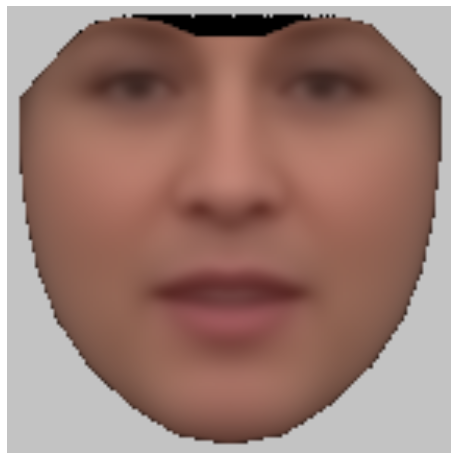

In [24]:
# Mean Face
instance = render_instance()
instance.view()

# Render Some Classifications

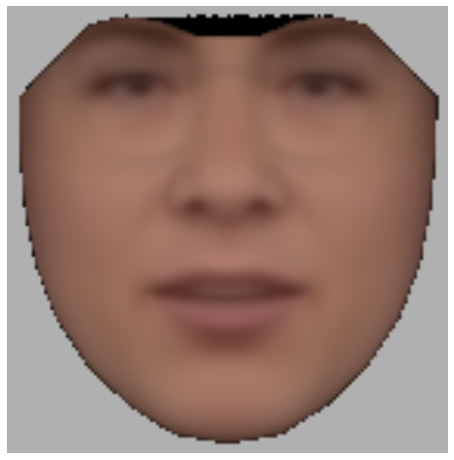

In [176]:
inv_shape = r.X[r.y_age > 5,:].mean(0)[r.inds_shape-1]
inv_texture = r.X[r.y_age > 5,:].mean(0)[r.inds_texture-1]
instance = render_instance(inv_shape, inv_texture)
instance.view()

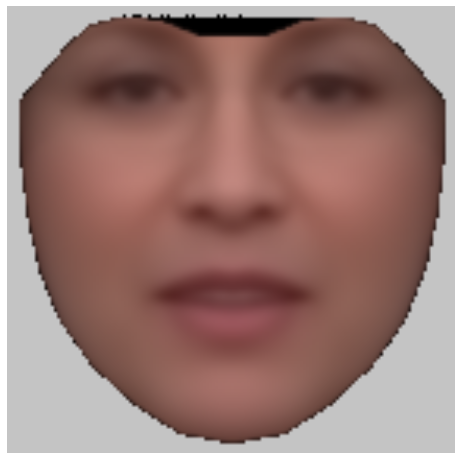

In [180]:
inv_shape = r.X[r.y_age < 1,:].mean(0)[r.inds_shape-1]
inv_texture = r.X[r.y_age < 1,:].mean(0)[r.inds_texture-1]
instance = render_instance(inv_shape, inv_texture)
instance.view()

In [179]:
r.y_age[r.y_age < 1]

array([ 0.8       ,  0.8       ,  0.16666667,  0.83333333,  0.16666667,
        0.8       ,  0.4       ,  0.6       ,  0.8       ,  0.8       ,
        0.8       ,  0.8       ,  0.        ,  0.6       ,  0.83333333,
        0.6       ,  0.8       ,  0.6       ,  0.33333333,  0.8       ,
        0.        ,  0.8       ,  0.2       ,  0.6       ,  0.8       ,
        0.6       ,  0.8       ,  0.77777778,  0.66666667,  0.66666667,
        0.6       ,  0.8       ,  0.4       ,  0.6       ,  0.6       ,
        0.6       ,  0.33333333,  0.66666667,  0.8       ,  0.8       ,
        0.88888889,  0.2       ,  0.2       ,  0.6       ,  0.8       ,
        0.8       ,  0.8       ,  0.8       ,  0.6       ,  0.77777778,
        0.6       ,  0.2       ,  0.6       ,  0.8       ,  0.11111111,
        0.44444444,  0.8       ,  0.8       ,  0.66666667,  0.11111111,
        0.66666667,  0.55555556])

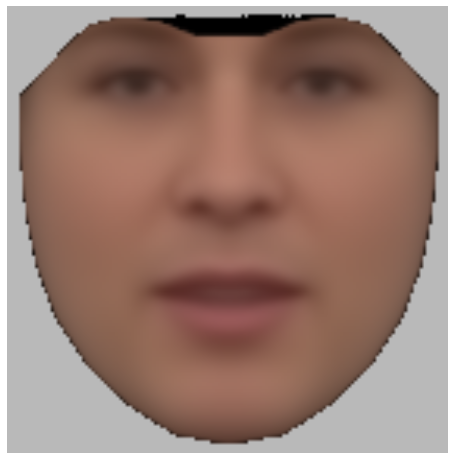

In [155]:
inv_shape, inv_texture = inv_shape_texture(4)
instance = render_instance(inv_shape, inv_texture)
instance.view()

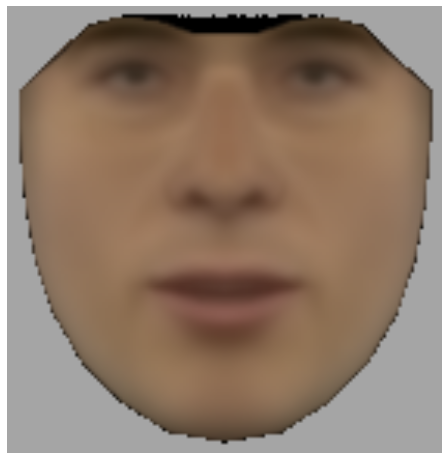

In [164]:
inv_shape, inv_texture = inv_shape_texture2(9)
instance = render_instance(inv_shape, inv_texture)
instance.view()

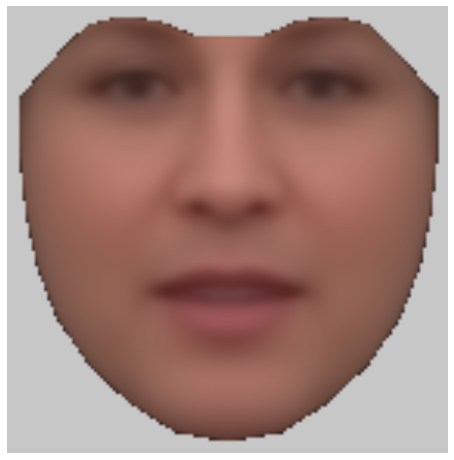

In [35]:
pca_texture.instance(coef_texture.age * -1, normalized_weights=True).view()

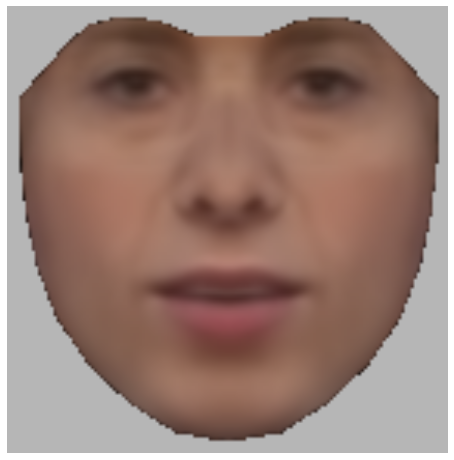

In [56]:
pca_texture.instance(coef_texture.attractive*-12, normalized_weights=False).view()

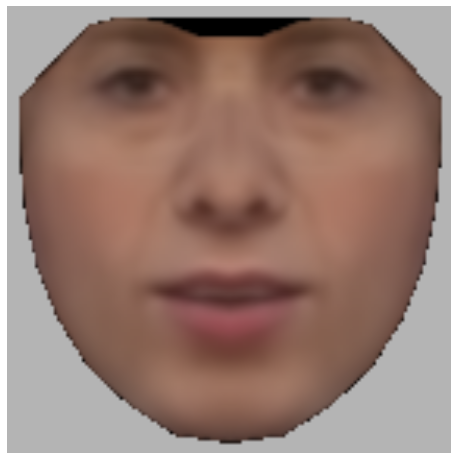

In [57]:
instance = render_instance(coef_shape.attractive * -12, coef_texture.attractive * -12)
instance.view()

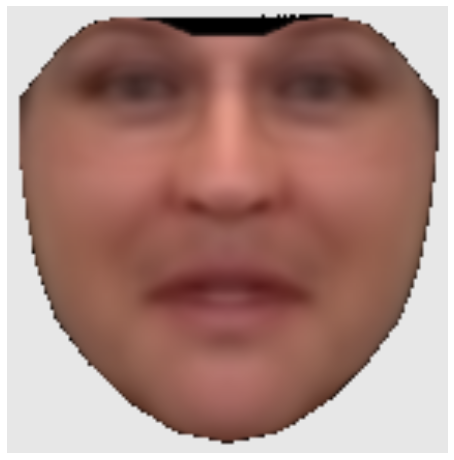

In [58]:
instance = render_instance(coef_shape.attractive * +12, coef_texture.attractive * +12)
instance.view()

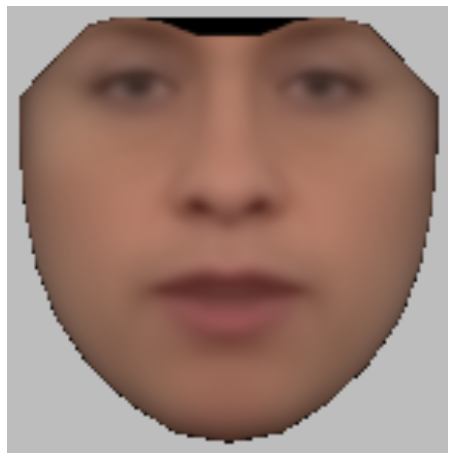

In [64]:
instance = render_instance(coef_shape.gender * +2, coef_texture.gender * +2)
instance.view()

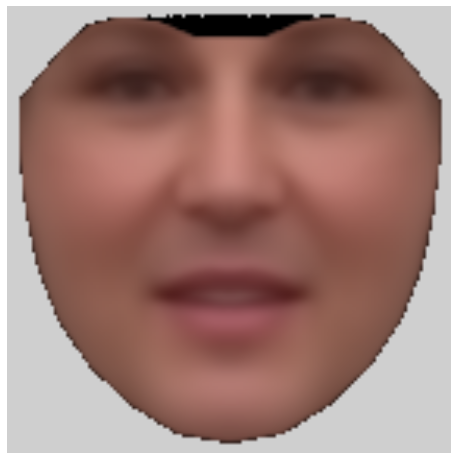

In [66]:
instance = render_instance(coef_shape.gender * -2, coef_texture.gender * -2)
instance.view()

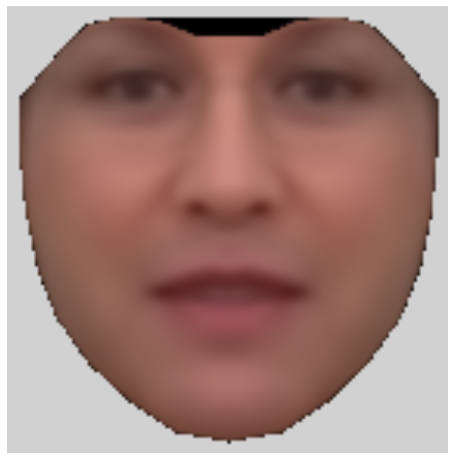

In [70]:
instance = render_instance(coef_shape.age * -6, coef_texture.age * -6)
instance.view()

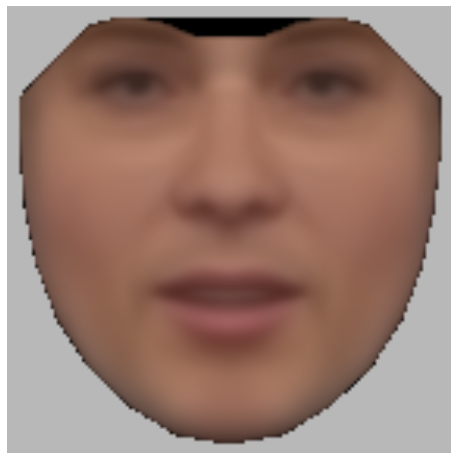

In [71]:
instance = render_instance(coef_shape.age * 7, coef_texture.age * 7)
instance.view()